# Simulate some data to test the method. branch = gyro_switch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

import read_mist_models
from isochrones.mist import MIST_Isochrone
from isochrones.dartmouth import Dartmouth_Isochrone
from isochrones import StarModel

from stardate.lhf import gyro_model_rossby, gyro_model

mist = MIST_Isochrone()
dart = Dartmouth_Isochrone()

/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/mist/grid.py:193: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = super(MISTModelGrid, self).df_all(phot)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['[Fe/H]']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [2]:
plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Draw randomly from mass, age, metallicity, distance and extinction distributions.

In [3]:
np.random.seed(42)
N = 1000
eep, eep_err = np.random.uniform(195, 480, size=N), np.ones(N)*10
age = np.log10(np.random.uniform(.5, 14, size=N)*1e9)
age_err = age*.2
feh, feh_err = np.random.uniform(-.2, .2, size=N), np.ones(N)*.01
mass = mist.mass(eep, age, feh)
d_kpc = np.random.uniform(.01, 1, size=N)
dkpc_err = d_kpc*.1
d_pc = d_kpc*1e3
dpc_err = d_pc*.1
av, av_err = np.random.uniform(0, .1, size=N), np.ones(N)*.01

# N = 1000
# eep, eep_err = np.random.uniform(250, 320, size=N), np.ones(N)*10
# age = np.log10(np.random.uniform(1, 3, size=N)*1e9)
# age_err = age*.2
# feh, feh_err = np.random.randn(N)*.01, np.ones(N)*.01
# mass = mist.mass(eep, age, feh)
# d_kpc = np.random.uniform(.01, 1, size=N)
# dkpc_err = d_kpc*.1
# d_pc = d_kpc*1e3
# dpc_err = d_pc*.1
# av, av_err = np.random.uniform(0, .1, size=N), np.ones(N)*.01

# Save as a pandas data frame
df = pd.DataFrame(dict({"eep": eep, "eep_err": eep_err,
                        "age": age, "age_err": age_err,
                        "feh": feh, "feh_err": feh_err,
                        "d_kpc": d_kpc, "dkpc_err": dkpc_err,
                        "Av": av, "Av_err": av_err}))

Use isochrones model to predict $T_\mathrm{eff}$, observed metallicity, $\hat{F}$, apparent magnitudes $J$, $H$, $K$, $B$, $V$, $\log(g)$ and parallax. Use Gyrochronology model to predict rotation period from age and $B$-$V$ color.

In [4]:
logg, teff, B, V, J, H, K, logL = [np.zeros(N) for i in range(8)]
for i in range(N):
    logg[i] = mist.logg(eep[i], age[i], feh[i])
    teff[i] = mist.Teff(eep[i], age[i], feh[i])
    B[i] = mist.mag["B"](eep[i], age[i], feh[i], d_pc[i], av[i])
    V[i] = mist.mag["V"](eep[i], age[i], feh[i], d_pc[i], av[i])
    J[i] = mist.mag["J"](eep[i], age[i], feh[i], d_pc[i], av[i])
    H[i] = mist.mag["H"](eep[i], age[i], feh[i], d_pc[i], av[i])
    K[i] = mist.mag["K"](eep[i], age[i], feh[i], d_pc[i], av[i])
    logL[i] = mist.logL(eep[i], age[i], feh[i])
    
df["BV"], df["B"], df["V"], df["jmag"], df["hmag"], df["kmag"] = B - V, B, V, J, H, K
df["logg"], df["teff"], df["logL"], df["parallax"] = logg, teff, logL, 1./d_kpc
df["mass"] = mist.mass(df.eep, df.age, df.feh)

Plot the simulated data on an HR diagram.

Text(0,0.5,'$\\log(g)$')

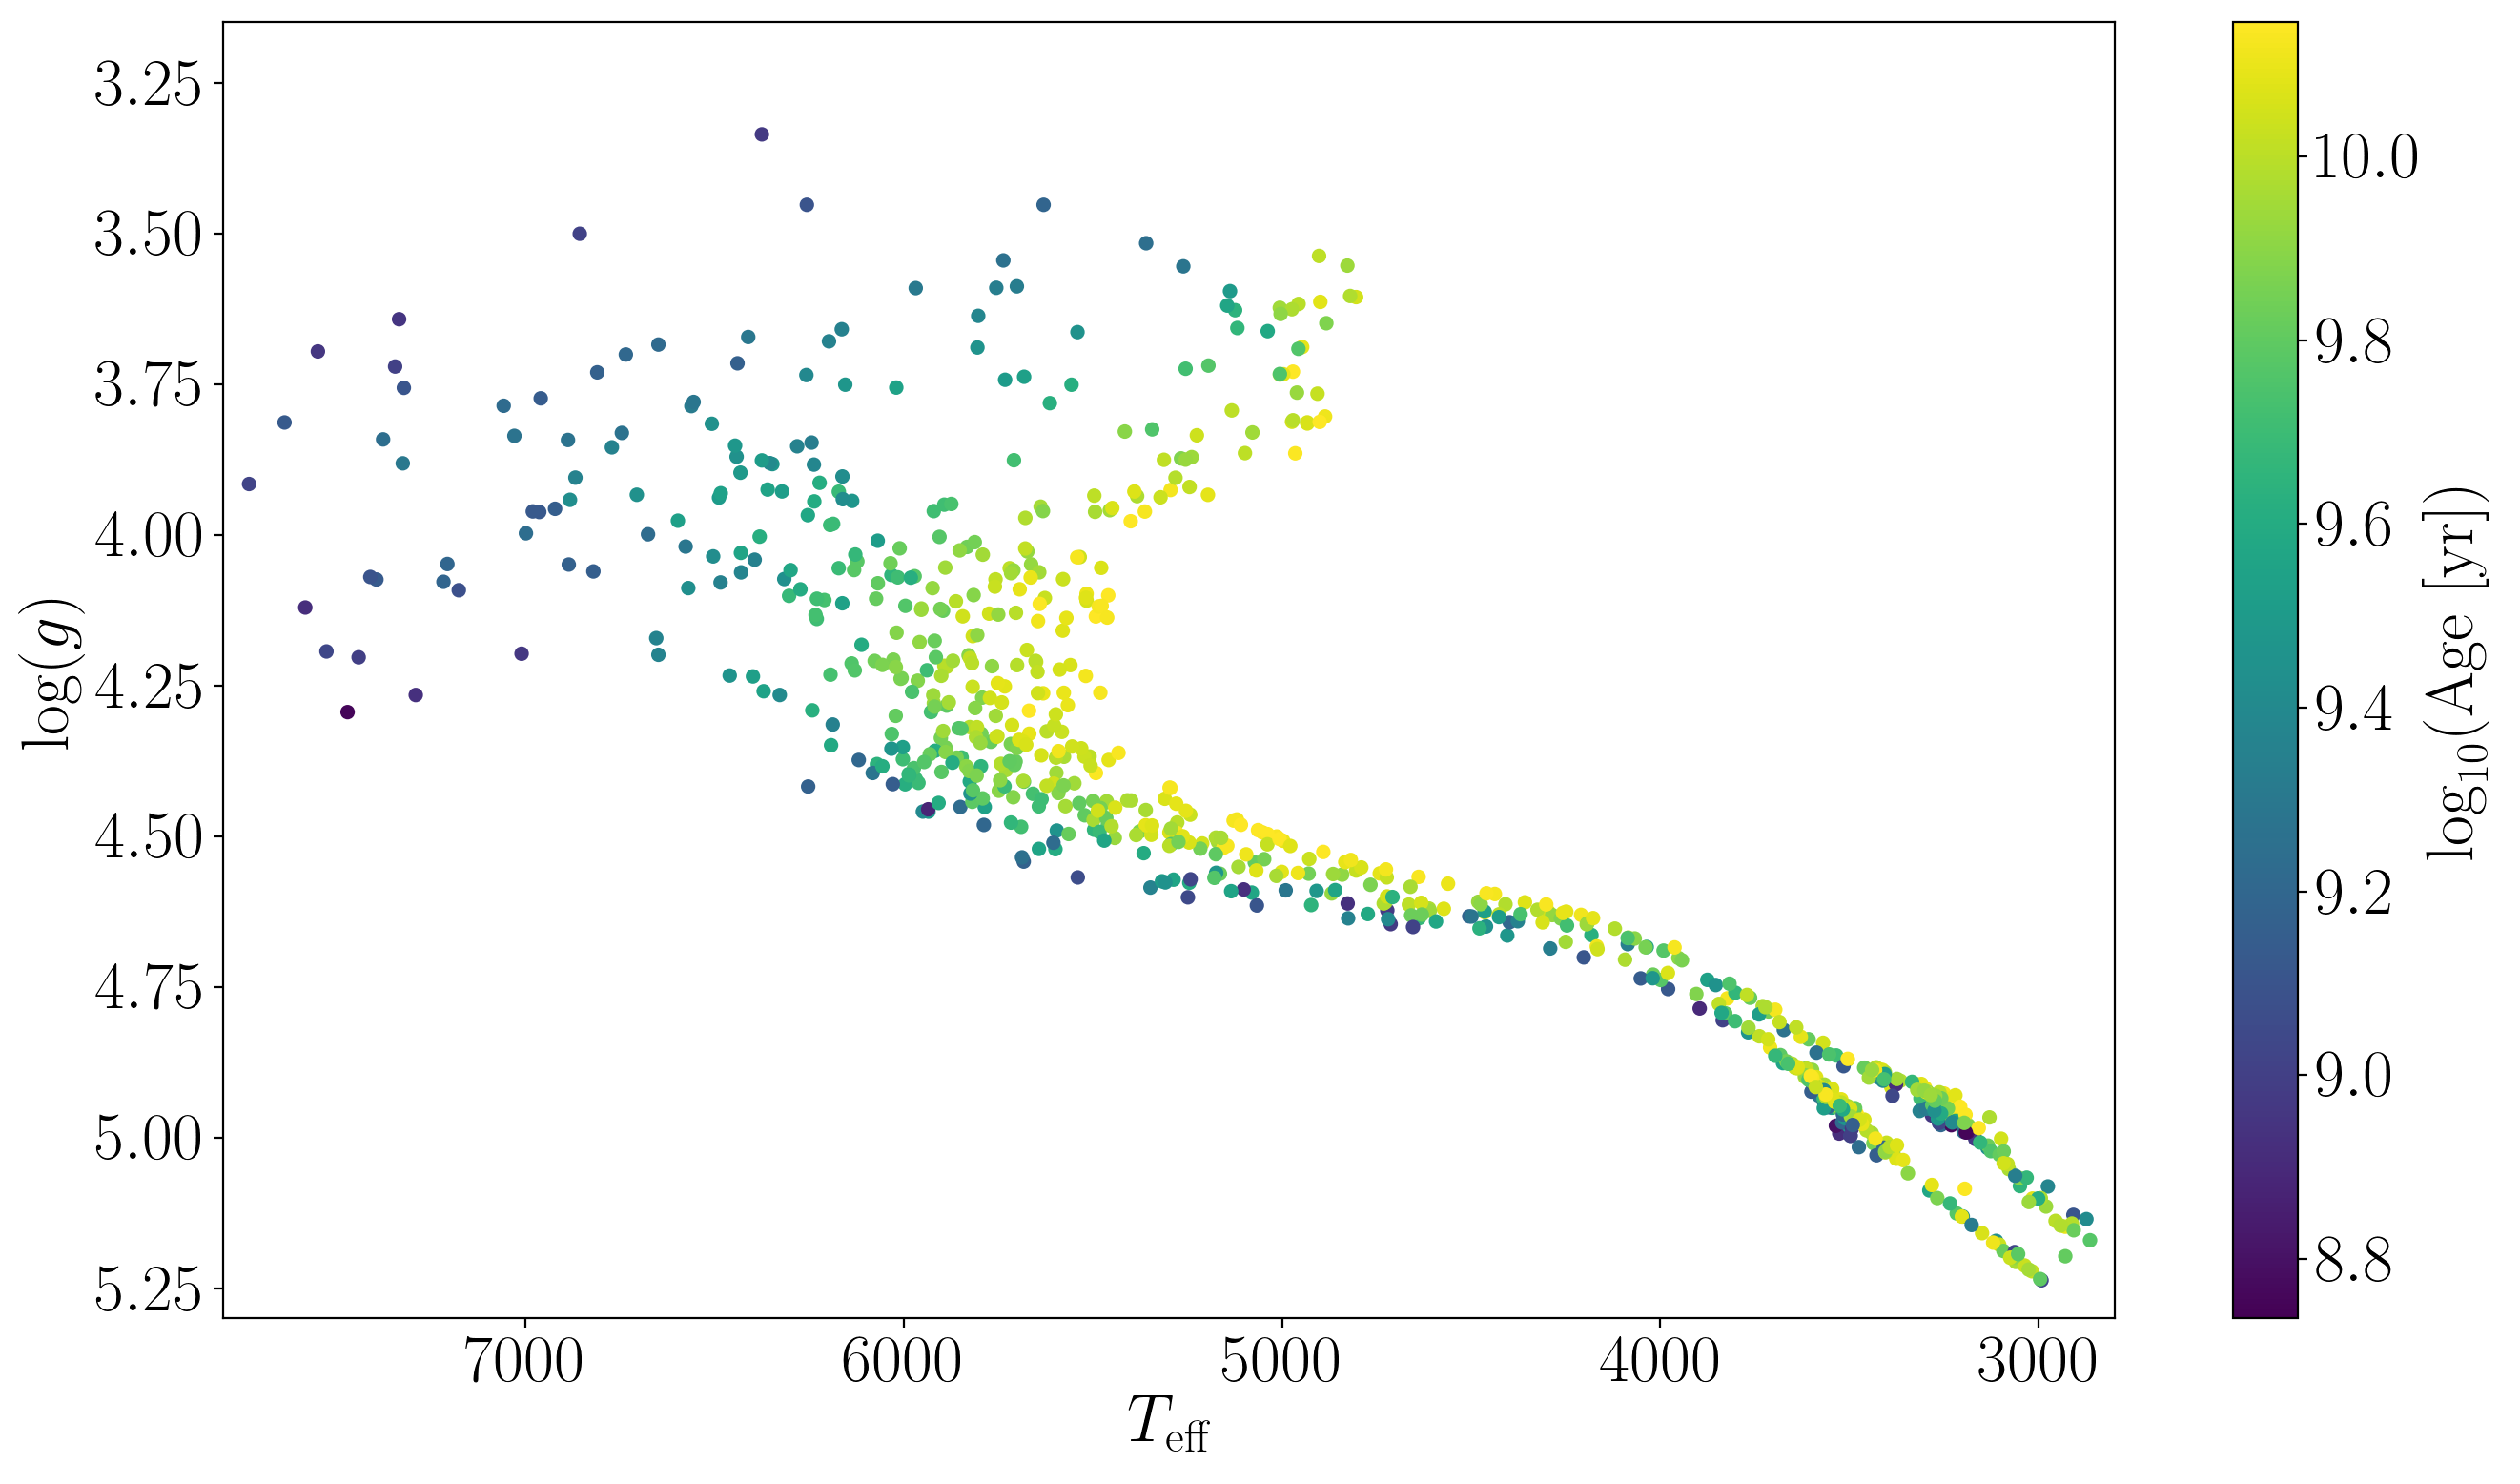

In [5]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(teff, logg, c=age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now calculate the rotation periods of these stars from their ages and B-V colours.

In [6]:
def gyro_rot(log_age_yr, bv):
    age_myr = (10**(log_age_yr))*1e-6
    a, b, c, n = [.4, .31, .45, .55]
    return age_myr**n * a * (bv - c)**b

def gyro_age(period, bv):
    a, b, c, n = [.4, .31, .45, .55]
    return np.log10(((period/(a*(bv-c)**b))**(1./n))*1e6)

Calculate periods for these stars.

In [7]:
# Calculate periods. NaNs will appear for stars with B-V < 0.45
prot = np.empty(N)
for i in range(N):
    prot[i] = gyro_model_rossby(df.age.values[i], df.BV.values[i], 
                                df.mass.values[i], rossby=True)
    
# random periods for cool stars.
cool_mask = df.BV > 1.25
prot[cool_mask] = 10**(np.random.randn(len(prot[cool_mask]))*.55 + .5)

# Random periods for hot stars.
hot_mask = .45 > df.BV
prot[hot_mask] = 10**(np.random.randn(len(prot[hot_mask]))*.55 + .5)

# # Give the evolved stars randomly distributed rotation periods
evolved_mask = (454 < df.eep) * (.45 < df.BV)
prot[evolved_mask] += np.random.randn(len(prot[evolved_mask]))*10

df["prot"] = prot

# Cut unphysical masses
finite_mask = np.isfinite(df.mass.values)
finite_df = df.iloc[finite_mask]
print(len(df.mass.values), "stars originally, ", len(df.mass.values[finite_mask]), "after cuts")

1000 stars originally,  860 after cuts


/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.2rc0-py3.5.egg/stardate/lhf.py:116: RuntimeWarning: invalid value encountered in double_scalars
  age_thresh_myr = (pmax/(a*(bv-c)**b))**(1./n)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Text(0,0.5,'$\\mathrm{Rotation~period~[days]}$')

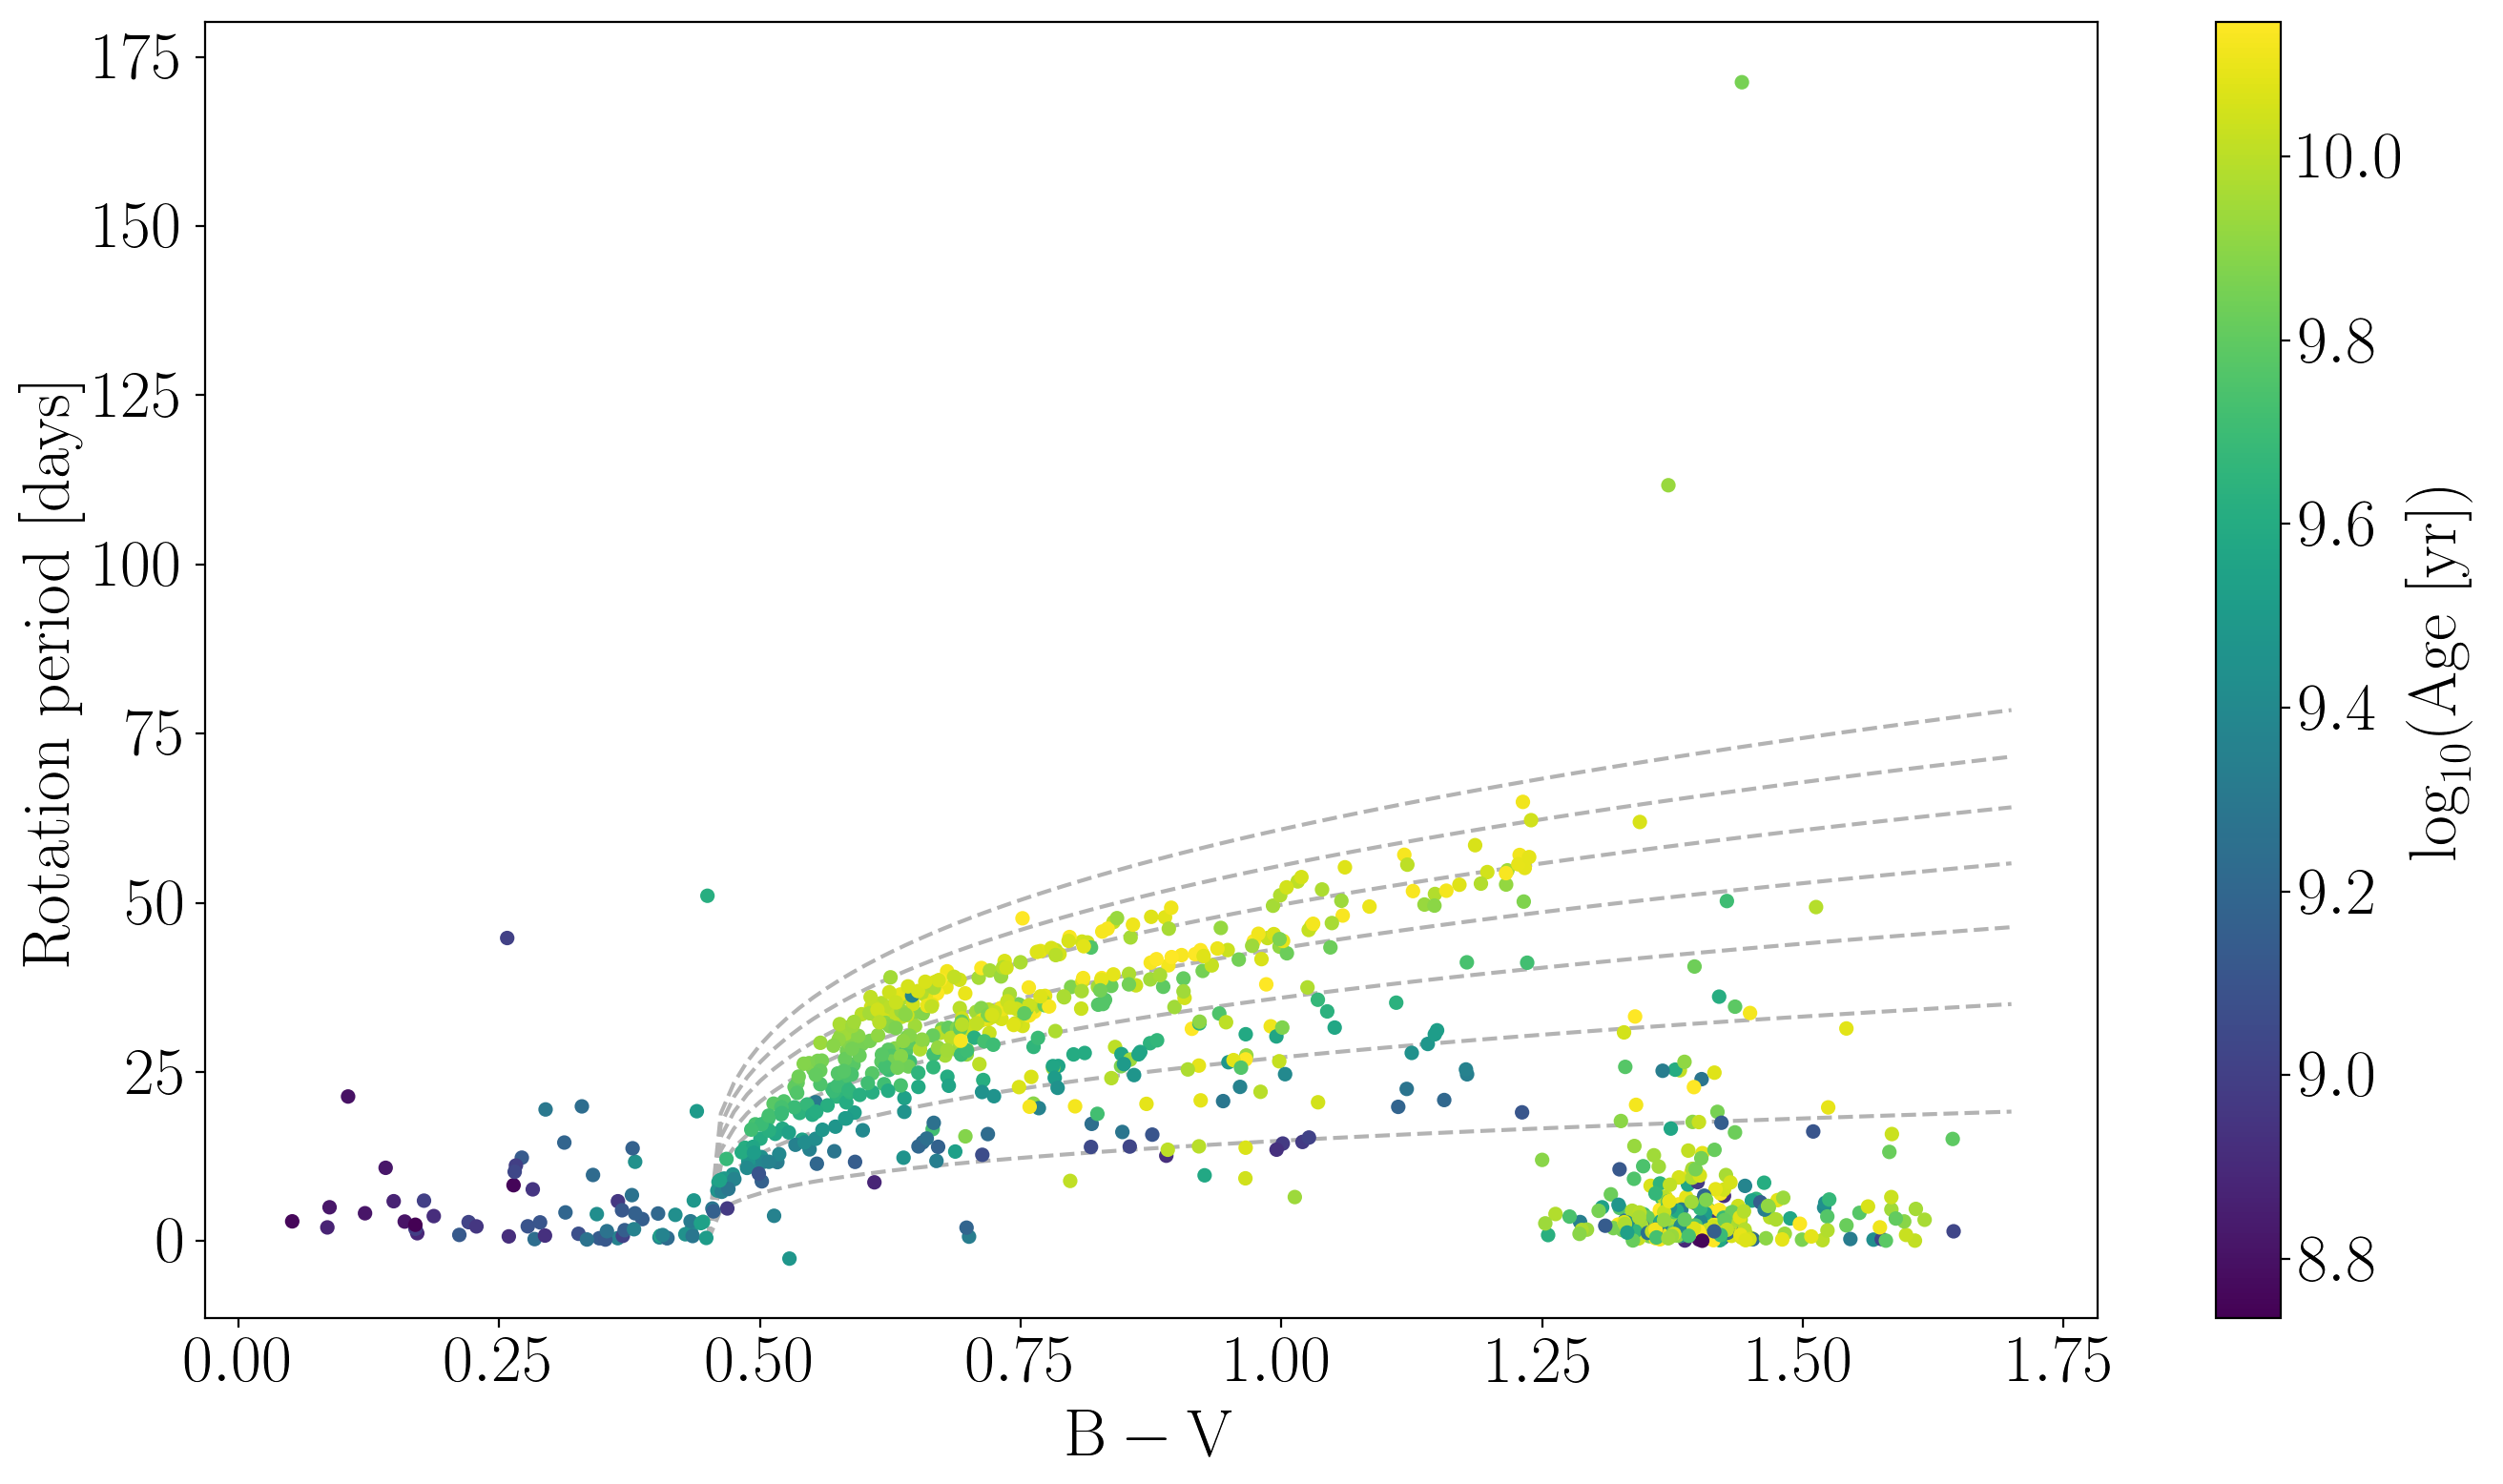

In [9]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.45, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

plt.scatter(finite_df.BV, finite_df.prot, c=finite_df.age, s=20, zorder=1)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

/Users/ruthangus/anaconda/lib/python3.5/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Text(0,0.5,'$\\mathrm{Rotation~period~[days]}$')

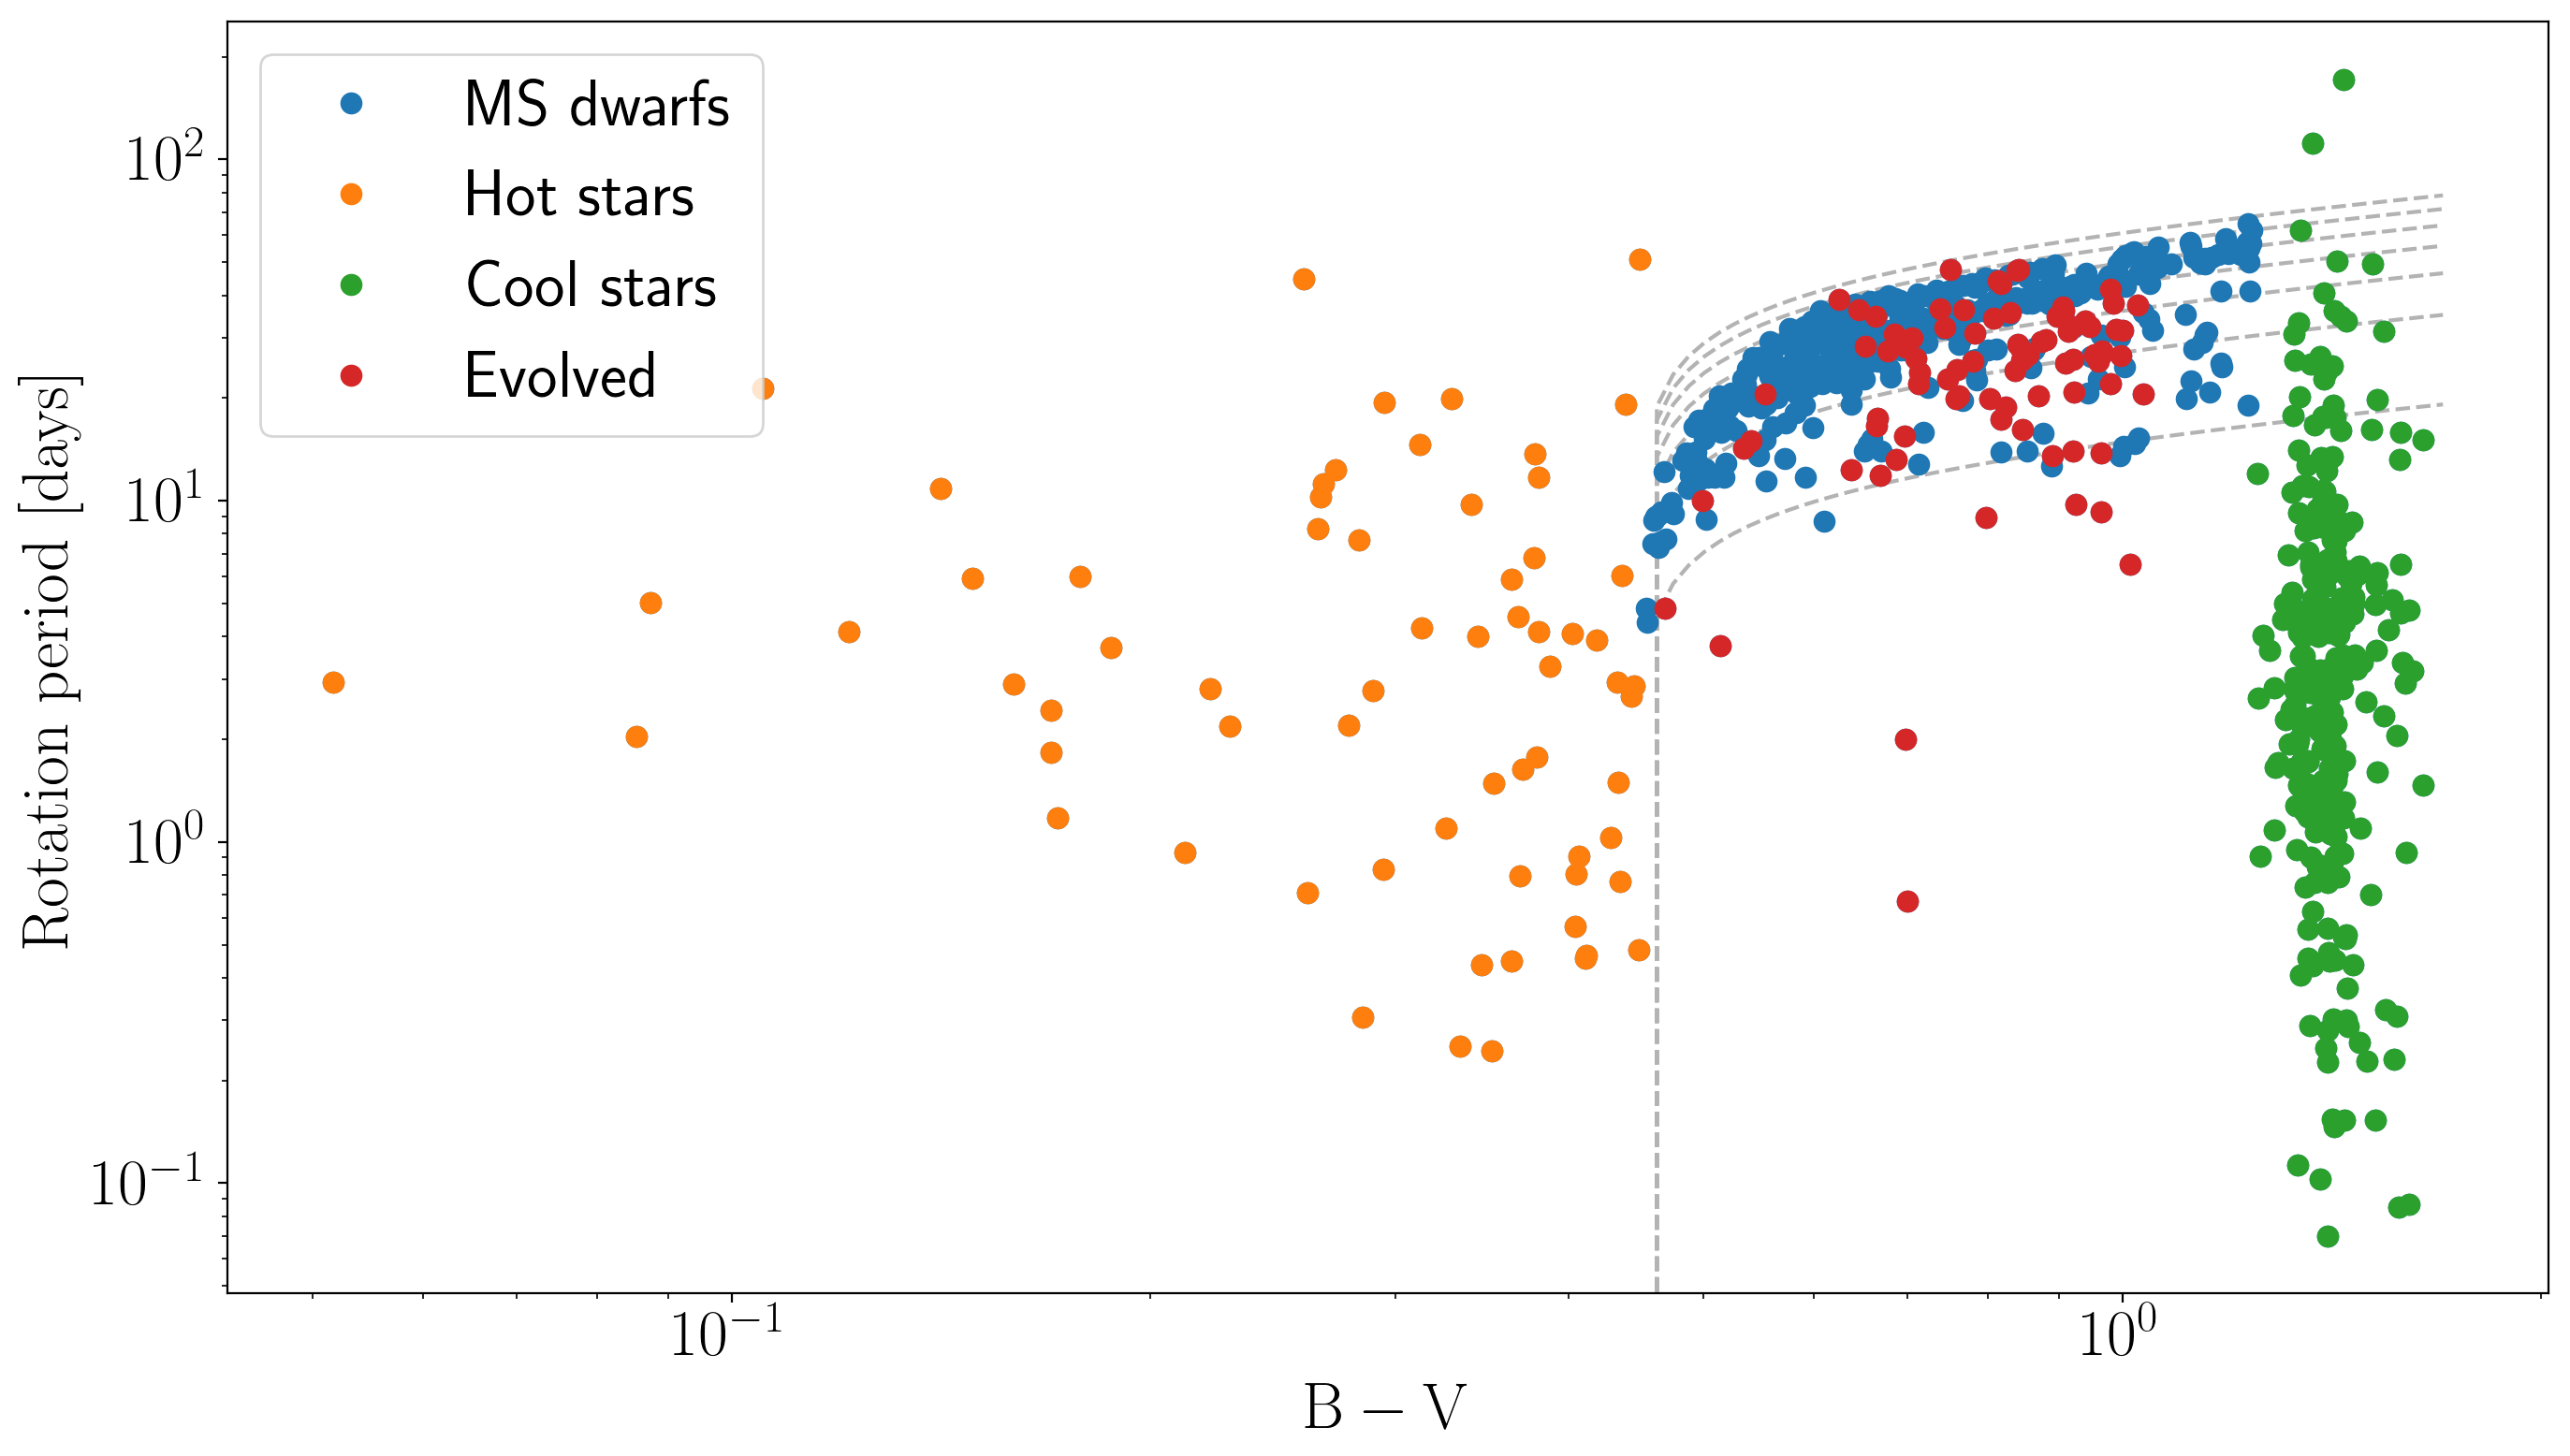

In [17]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.45, 1.7, 100)
for a in range(1, 14, 2):
    plt.loglog(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

hot_mask = finite_df.BV < .45
cool_mask = 1.25 < finite_df.BV
evolved_mask = (.45 < finite_df.BV) * (454 < finite_df.eep)

plt.loglog(finite_df.BV, finite_df.prot, ".", ms=15 , zorder=0, label="MS dwarfs")
plt.loglog(finite_df.BV[hot_mask], finite_df.prot[hot_mask], ".", ms=15 , zorder=1, label="Hot stars")
plt.loglog(finite_df.BV[cool_mask], finite_df.prot[cool_mask], ".", ms=15 , zorder=1, label="Cool stars")
plt.loglog(finite_df.BV[evolved_mask], finite_df.prot[evolved_mask], ".", ms=15, zorder=1, label="Evolved")
plt.legend()
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.2rc0-py3.5.egg/stardate/lhf.py:116: RuntimeWarning: divide by zero encountered in double_scalars
  age_thresh_myr = (pmax/(a*(bv-c)**b))**(1./n)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.2rc0-py3.5.egg/stardate/lhf.py:121: RuntimeWarning: divide by zero encountered in log10
  log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)


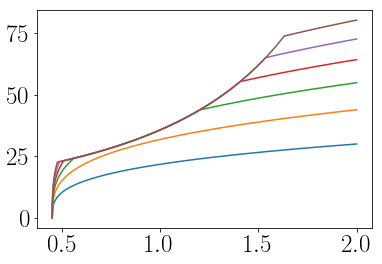

In [18]:
bv_plot = np.linspace(.45, 2., 1000)
mass_plot = np.linspace(1.25, .3, 1000)
period_plot = np.empty((14, 1000))

for j in range(14):
    for i in range(1000):
        period_plot[j, i] = gyro_model_rossby(np.log10(j*1e9), bv_plot[i], mass_plot[i])
plt.plot(bv_plot, period_plot[2, :])
plt.plot(bv_plot, period_plot[4, :])
plt.plot(bv_plot, period_plot[6, :])
plt.plot(bv_plot, period_plot[8, :])
plt.plot(bv_plot, period_plot[10, :])
plt.plot(bv_plot, period_plot[12, :])

Text(0,0.5,'$\\mathrm{Rotation~period~[days]}$')

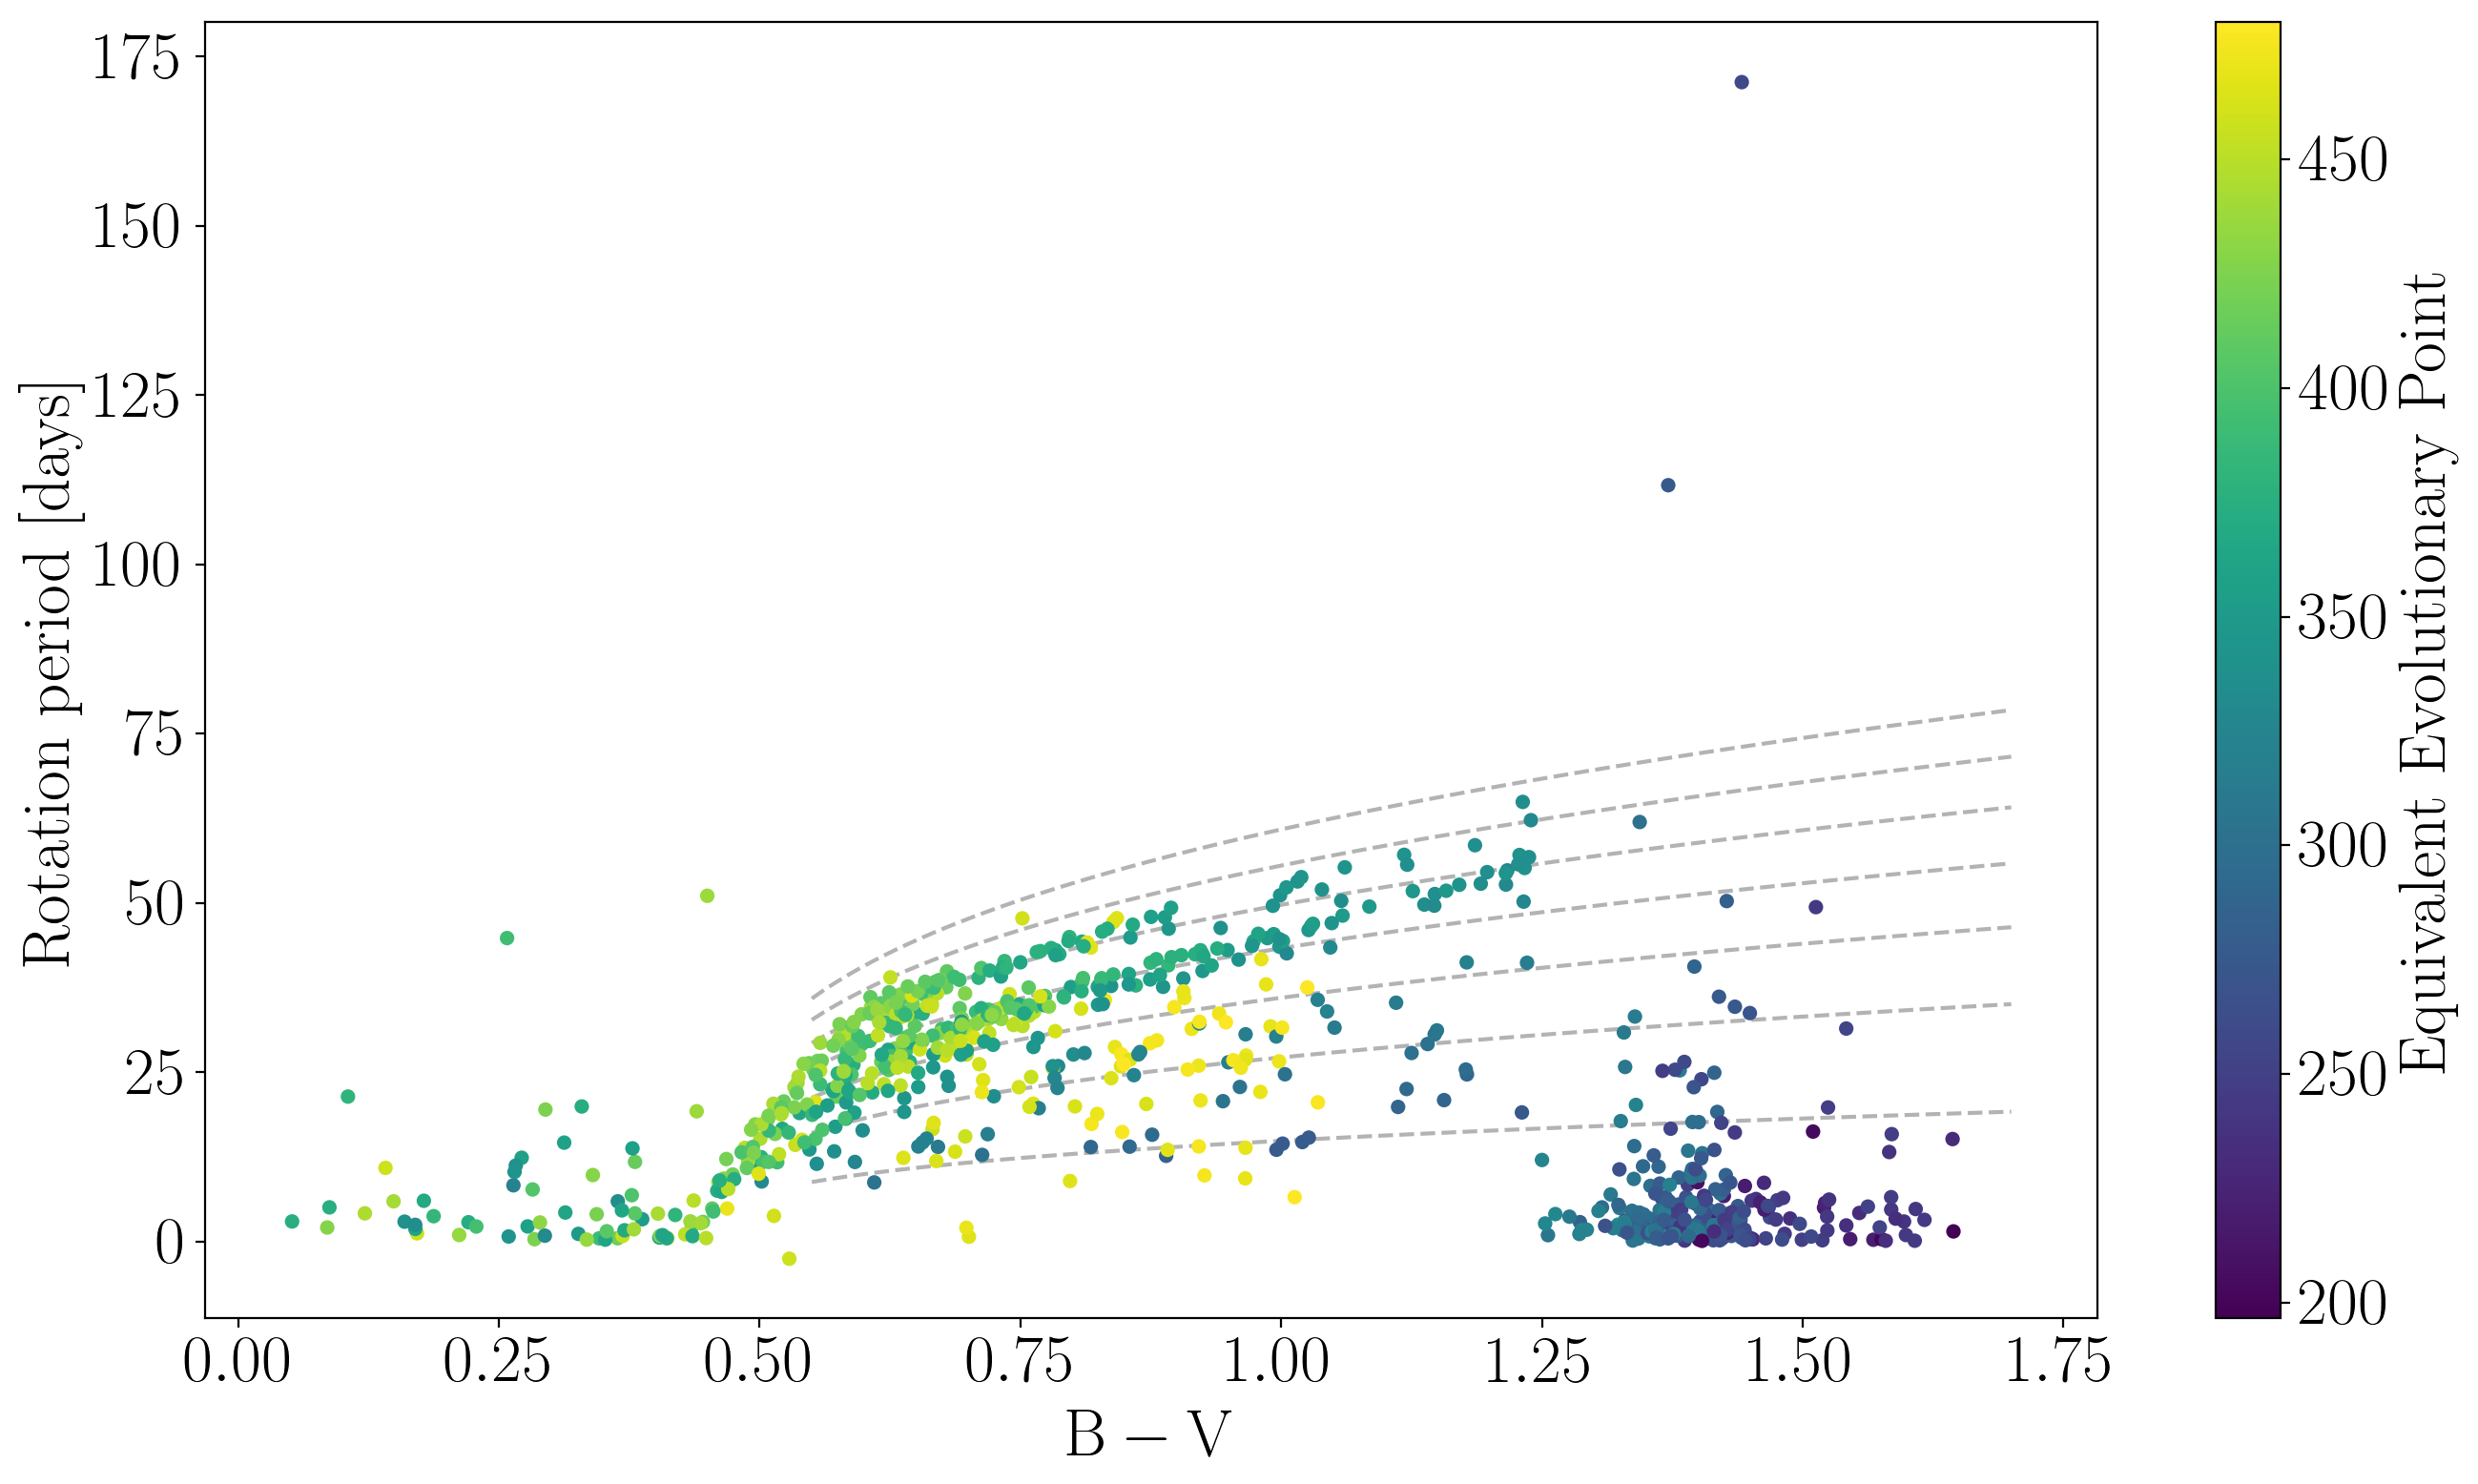

In [19]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.55, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

plt.scatter(finite_df.BV, finite_df.prot, c=finite_df.eep, s=20, zorder=1)
plt.colorbar(label="$\mathrm{Equivalent~Evolutionary~Point}$")
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

Save simulated data file.

In [12]:
finite_df["ID"]
finite_df.to_csv("data/simulated_data.csv")

In [ ]:
plt.hist(finite_df.mass, 25);
plt.xlabel("$\mathrm{Mass~}[M_\odot]$")